In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, GroupKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix, recall_score, roc_curve, auc, make_scorer
from sklearn.preprocessing import label_binarize
from sklearn.inspection import permutation_importance
from sklearn.manifold import TSNE
from imblearn.over_sampling import BorderlineSMOTE

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# df = pd.read_csv('/gdrive/My Drive/datos ADNI/preprocessed_data.csv')
df = pd.read_csv('/gdrive/My Drive/datos ADNI/preprocessed_data_version_lao.csv')

base_dir_img = '/gdrive/My Drive/datos ADNI/images'

In [ ]:
print(f'Cantidad de sujetos: {len(df["RID"].unique())}')

Cantidad de sujetos: 544


In [ ]:
 df['DIAGNOSIS'].value_counts()

MCI    601
AD     248
NL      99
Name: DIAGNOSIS, dtype: int64

# Hago un split para quedarnos con un heldout final

In [ ]:
TARGET_COLS = ['RID', 'DIAGNOSIS', 'CONVERSION_MONTH', 'DIAGNOSIS_code']
FEATURE_COLS = list(set(df.columns) - set(TARGET_COLS))
X = df[FEATURE_COLS].values
y = df['DIAGNOSIS_code'].values
groups = df['RID'].values

print(f'Shape X: {X.shape}')
print(f'Shape y: {y.shape}')

Shape X: (948, 146)
Shape y: (948,)


In [ ]:
gss = GroupShuffleSplit(
    n_splits=1,
    test_size=0.15,
    random_state=42
)

train_index, test_index = next(gss.split(X, y, groups))

X_train, X_heldout = X[train_index], X[test_index]
y_train, y_heldout = y[train_index], y[test_index]
g_train, g_heldout = groups[train_index], groups[test_index]

print(f'Shape X_train: {X_train.shape}')
print(f'Shape X_heldout: {X_heldout.shape}')
print(f'Shape y_train: {y_train.shape}')
print(f'Shape y_heldout: {y_heldout.shape}')

Shape X_train: (802, 146)
Shape X_heldout: (146, 146)
Shape y_train: (802,)
Shape y_heldout: (146,)


In [ ]:
# Miro que el stratify se mantuvo mas o menos

print('\n train')
print(pd.Series(y_train).value_counts() / y_train.shape[0])
print('\n Heldout')
print(pd.Series(y_heldout).value_counts() / y_heldout.shape[0])


 train
1.0    0.622195
2.0    0.266833
0.0    0.110973
dtype: float64

 Heldout
1.0    0.698630
2.0    0.232877
0.0    0.068493
dtype: float64


In [ ]:
# Miro que no hay sujetos que esten en train y heldout a la misma vez

set(g_train) & set(g_heldout)

set()

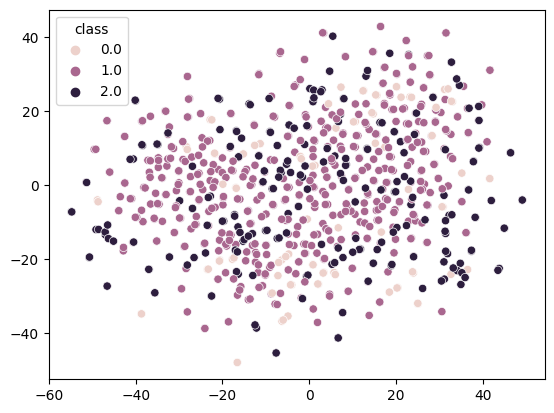

In [ ]:
X_embedded = pd.DataFrame(TSNE(n_components=2).fit_transform(X_train), columns=['x1', 'x2'])
X_embedded['class'] = y_train

sns.scatterplot(x='x1', y='x2', hue='class', data=X_embedded)
plt.xlabel('')
plt.ylabel('')
plt.show()

In [ ]:
 def evaluate_clasiffier(estimator, X, y, groups, model_name, n_splits=5):
  # Uso este wrapper para poder probar cualquier clasificador sin tener
  # que estar pendientes de si tiene o no la posibilidad de hacer multiclass
  clf = OneVsRestClassifier(estimator)

  classes = np.unique(y)
  n_classes = classes.shape[0]

  y_true = []
  y_probas = []
  y_preds = []
  gkf = GroupKFold(n_splits=n_splits)

  for train_index, test_index in gkf.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf.fit(X_train, y_train)

    y_true.append(y_test)
    y_probas.append(clf.predict_proba(X_test))
    y_preds.append(clf.predict(X_test))

    # Solo por TOC voy a chequear que el modelo asigna siempre las clases en
    # orden 0, 1, 2 para asegurarnos que no mezcla ordenes en distintos folds
    assert all(classes == clf.classes_)

  y_true = np.concatenate(y_true)
  y_probas = np.concatenate(y_probas)
  y_preds = np.concatenate(y_preds)

  evaluate_resutls(y_true, y_probas, y_preds, model_name)


def evaluate_resutls(y_true, y_probas, y_preds, model_name):

  n_classes = y_probas.shape[1]

  class_labels = [
    'NL: ',
    'MCI:',
    'AD: '
  ]

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_probas[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Plot of a ROC curve for a specific class
  plt.plot([0, 1], [0, 1], 'k--')
  for i in range(n_classes):
      sns.lineplot(
          x=fpr[i],
          y=tpr[i],
          label=f'{class_labels[i]} AUC = {roc_auc[i]:.2f}'
      )

  plt.xlabel('False Positive Rate', fontsize=14)
  plt.ylabel('True Positive Rate', fontsize=14)
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.savefig(os.path.join(base_dir_img,f'{model_name}_roc.png'))
  plt.show()

  print('\n\n')

  cm = pd.DataFrame(
      confusion_matrix(y_true,y_preds),
      columns=['NL', 'MCI', 'AD'],
      index=['NL', 'MCI', 'AD'],
  )
  sns.heatmap(cm, annot=True, cmap='flare', fmt='g')
  plt.title('Confusion matrix')
  plt.savefig(os.path.join(base_dir_img,f'{model_name}_confusion_matrix.png'))
  plt.show()

  print(f'Recall: {recall_score(y_true, y_preds, average="weighted")}')

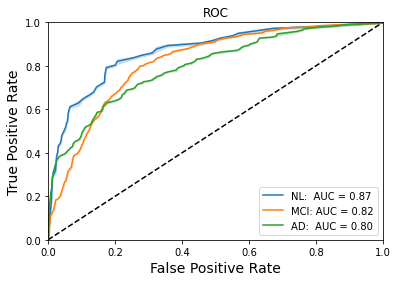

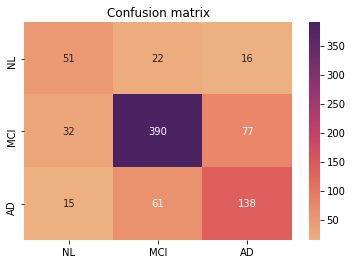

Recall: 0.7219451371571073


In [ ]:
clf = LogisticRegression(
    class_weight='balanced',
    max_iter=1000000,
    warm_start=False # Default es False, pero por las dudas lo explicito.
)

evaluate_clasiffier(clf, X_train, y_train, g_train, 'modelo_initial_train', n_splits=5)

In [ ]:
gscv = GridSearchCV(
    clf,
    param_grid={
        'penalty': ['l1','l2'],
        'C': np.arange(0,5,0.2),
        'solver': ['sag','saga','liblinear','lbfgs']
    },
    scoring=make_scorer(recall_score, average='weighted'),
    refit=True,
    n_jobs=-1,
    cv=GroupKFold(n_splits=5).split(X_train,y_train,g_train),
    verbose=5
)

best_clf = gscv.fit(X_train, y_train)

df_gs = pd.DataFrame(best_clf.cv_results_)
df_gs = df_gs[[c for c in df_gs.columns if 'param_' in c] + ['mean_test_score',	'std_test_score',	'rank_test_score']]

print('\n')
display(df_gs)
print(f'\nBest estimator recall: {best_clf.best_score_}')
print(f'Best estimator recall: {best_clf.best_params_}')

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 230 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 356 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 716 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 950 tasks      | elapsed:  8.9min


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  9.6min finished


,param_C,param_penalty,param_solver,mean_test_score,std_test_score,rank_test_score
0,0,l1,sag,NaN,NaN,157
1,0,l1,saga,0.298284,0.212312,145
2,0,l1,liblinear,NaN,NaN,176
3,0,l1,lbfgs,NaN,NaN,175
4,0,l2,sag,NaN,NaN,174
...,...,...,...,...,...,...
195,4.8,l1,lbfgs,NaN,NaN,147
196,4.8,l2,sag,0.698238,0.043389,106
197,4.8,l2,saga,0.700722,0.046607,91
198,4.8,l2,liblinear,0.728191,0.041693,20



Best estimator recall: 0.7344798136645962
Best estimator recall: {'C': 0.4, 'penalty': 'l2', 'solver': 'liblinear'}


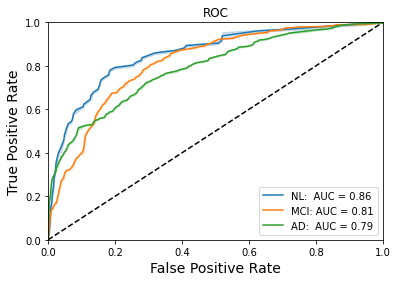

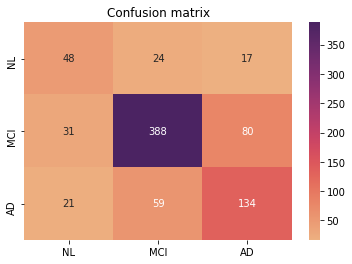

Recall: 0.7107231920199502


In [ ]:
clf_best_params = LogisticRegression(
    class_weight='balanced',
    max_iter=1000000,
    warm_start=False,
    penalty=best_clf.best_params_['penalty'],
    C=best_clf.best_params_['C'],
    solver=best_clf.best_params_['solver']
)
evaluate_clasiffier(clf_best_params, X_train, y_train, g_train, 'modelo_optimizado_train', n_splits=5)

# Evaluación en heldout

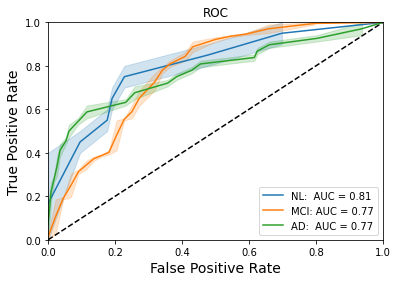

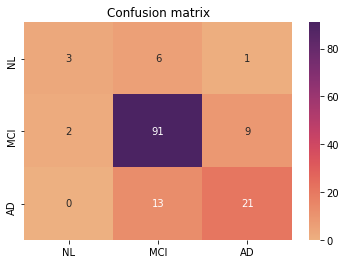

Recall: 0.7876712328767124


In [ ]:
y_probas = best_clf.predict_proba(X_heldout)
y_preds = best_clf.predict(X_heldout)

evaluate_resutls(y_heldout, y_probas, y_preds, 'modelo_optimizado_test')

# Data augmentation

La verdad es que no tiene mucho sentido hacer data augmentation. Y en el heldout la caga, lo que indica que solo agrega overfitting. Esto tiene sentido si miramos los resultados de t-SNE o PCA donde no se encuentran clusters claramente separados de los grupos

## Miro el count de cada clase para saber cuantos datos agregar de cadad clase

In [ ]:
pd.Series(y_train).value_counts()

1.0    499
2.0    214
0.0     89
dtype: int64

1.0    499
2.0    400
0.0    200
dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

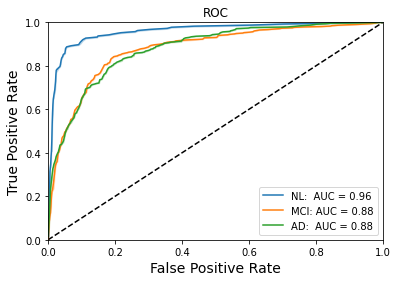

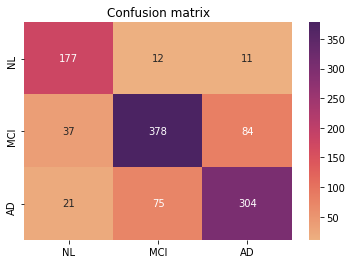

Recall: 0.7816196542311192


In [ ]:
oversample_dict = {
    0.0: 200,
    2.0: 400
}

smote = BorderlineSMOTE(sampling_strategy=oversample_dict)
resampled_X, resampled_y = smote.fit_resample(X_train, y_train)

print(pd.Series(resampled_y).value_counts())

resampled_g = np.concatenate([g_train,g_train.max() + np.arange(len(resampled_y) - len(y_train))])

evaluate_clasiffier(clf_best_params, resampled_X, resampled_y, resampled_g, 'modelo_optimizado_data_augmentation_train', n_splits=5)

# Evaluación data augmentation en heldout

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)

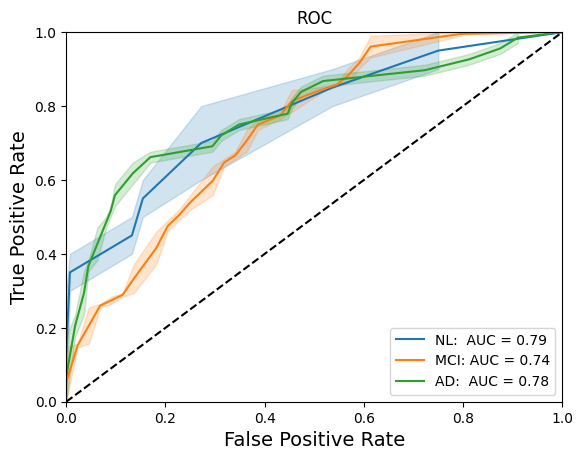

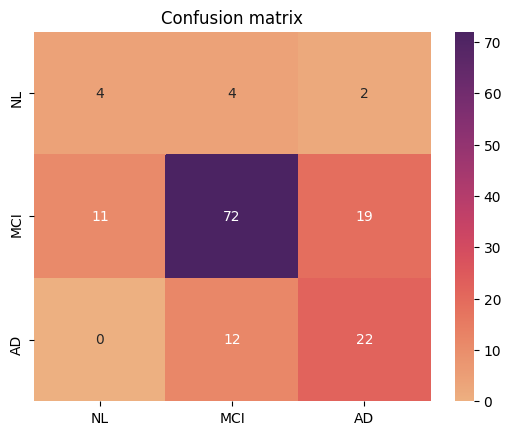

Recall: 0.6712328767123288


In [ ]:
clf_best_params.fit(resampled_X, resampled_y)

y_probas = clf_best_params.predict_proba(X_heldout)
y_preds = clf_best_params.predict(X_heldout)

evaluate_resutls(y_heldout, y_probas, y_preds, 'modelo_optimizado_data_augmentation_test')

# Feature importance

In [ ]:
df_test_relevance = pd.read_csv('/gdrive/My Drive/datos ADNI/blood_dict_to_complete.csv')

In [ ]:
n_features = 40
colors = sns.color_palette("ch:s=-.25,rot=.25", n_colors=4)

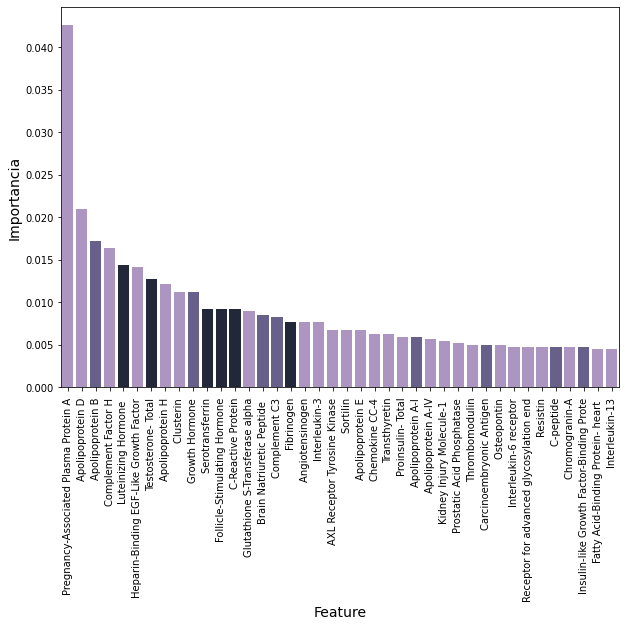

In [ ]:
fi = permutation_importance(
    best_clf,
    X_train,
    y_train,
    n_repeats=5,
    scoring=make_scorer(recall_score, average='weighted')
)

df_fi = pd.DataFrame(
    zip(fi['importances_mean'], FEATURE_COLS),
    columns=['importances_mean','feature']
)

df_fi = df_fi.merge(
    df_test_relevance[['blood_short_name', 'Es estandar', 'blood_fullnames']],
    left_on='feature',
    right_on='blood_short_name',
    how='left'
)

df_fi.sort_values(
    by='importances_mean',
    inplace=True,
    ignore_index=True,
    ascending=False
)

df_fi['color'] = df_fi['Es estandar'].apply(lambda x: colors[int(x)+1] if not np.isnan(x) else colors[0])

plt.rcParams["figure.figsize"] = (10, 7)
sns.barplot(
    x='feature',
    y='importances_mean',
    data=df_fi[:n_features],
    palette=list(df_fi[:n_features]['color'])
)

plt.xticks(
    plt.xticks()[0],
    labels=df_fi[:n_features]['blood_fullnames'].values,
    rotation=90
)
plt.ylabel('Importancia', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.tight_layout
plt.savefig(os.path.join(base_dir_img,'permutation_importance.png'))
plt.show()

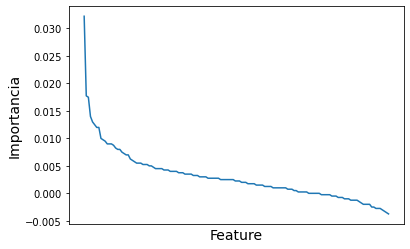

In [ ]:

sns.lineplot(
    x='feature',
    y='importances_mean',
    data=df_fi
)

plt.xticks([])
plt.ylabel('Importancia', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.savefig(os.path.join(base_dir_img,'permutation_importance_line.png'))
plt.show()

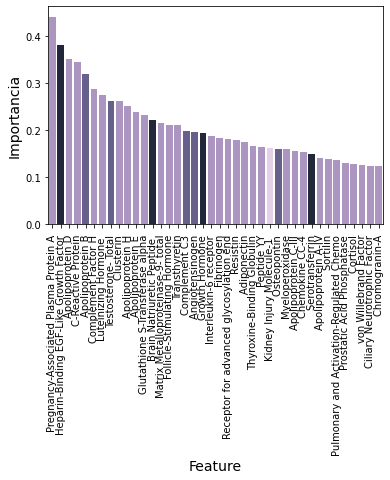

In [ ]:
# Mirar los pesos como feature importance ya que los datos están escaleados entre 0 y 1
df_coef = pd.DataFrame(
  np.abs(best_clf.best_estimator_.coef_.mean(axis=0)),
  columns=['coef']
)
df_coef['feature'] = FEATURE_COLS

df_coef = df_coef.merge(
    df_test_relevance[['blood_short_name','Es estandar']],
    left_on='feature',
    right_on='blood_short_name',
    how='left'
)

df_coef.sort_values(
    by='coef',
    inplace=True,
    ignore_index=True,
    ascending=False
)

df_coef['color'] = df_coef['Es estandar'].apply(lambda x: colors[int(x)+1] if not np.isnan(x) else colors[0])

sns.barplot(
    x='feature',
    y='coef',
    data=df_coef[:n_features],
    palette=list(df_coef[:n_features]['color'])
)
plt.xticks(
    plt.xticks()[0],
    labels=df_fi[:n_features]['blood_fullnames'].values,
    rotation=90
)

plt.ylabel('Importancia', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.savefig(os.path.join(base_dir_img,'logical_regresion_coefs.png'))
plt.show()

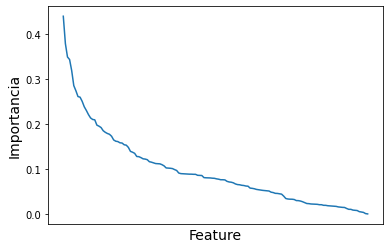

In [ ]:

sns.lineplot(
    x='feature',
    y='coef',
    data=df_coef
)

plt.xticks([])
plt.ylabel('Importancia', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.savefig(os.path.join(base_dir_img,'logical_regresion_coefs.png'))
plt.show()

# Miramos la performance del modelo utilizando solo tests estandares

## Mirando primero con test comunes y muy comunes (1 y 2)

In [ ]:
standar_tests = df_test_relevance[df_test_relevance['Es estandar'] > 0].blood_short_name
standar_tests_indexes = np.where(np.isin(FEATURE_COLS, standar_tests))[0]

X_train_standar = X_train[:,standar_tests_indexes]
X_heldout_standar = X_heldout[:,standar_tests_indexes]

print(f'X_train_standar shape: {X_train_standar.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'\nX_heldout_standar shape: {X_heldout_standar.shape}')
print(f'y_heldout shape: {y_train.shape}')

X_train_standar shape: (802, 37)
y_train shape: (802,)

X_heldout_standar shape: (146, 37)
y_heldout shape: (802,)


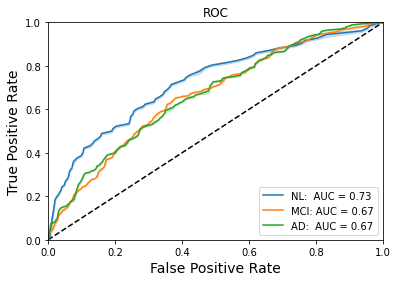

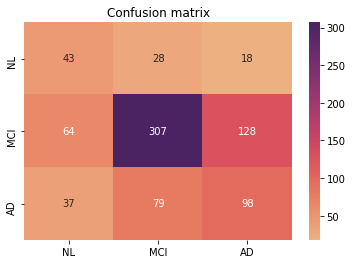

Recall: 0.5586034912718204


In [ ]:
evaluate_clasiffier(clf_best_params, X_train_standar, y_train, g_train, 'modelo_optimizado_features_comunes_train', n_splits=5)

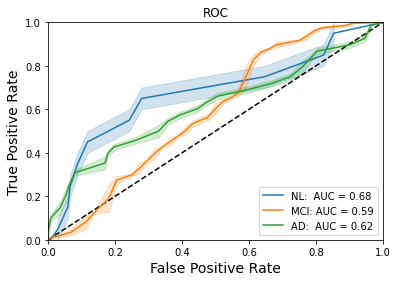

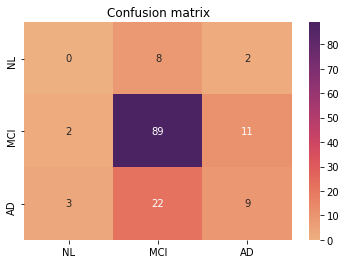

Recall: 0.6712328767123288


In [ ]:
clf_best_params.fit(X_train_standar, y_train)

y_probas = clf_best_params.predict_proba(X_heldout_standar)
y_preds = clf_best_params.predict(X_heldout_standar)

evaluate_resutls(y_heldout, y_probas, y_preds, 'modelo_optimizado_features_comunes_test')